In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode, re
from scipy.stats import pearsonr

#Load data from csv files 
osc = pd.read_csv("Oscar_information.csv")
box = pd.read_csv("total_domestic_box_office.csv")
top = pd.read_csv("top_grossing_movies_with_gross_clean.csv")

#remove extra spaces from column names for clean merging. 
box.columns = box.columns.str.strip()  


In [4]:
def clean_title(title):
    '''
    Standardizes movie titles. 
    Purpose: so datasets can match correctly
    '''
    if pd.isna(title):
        return None
    title = title.lower()
    #remove accent marks by converting characters to ASCII equivalent 
    title = unidecode.unidecode(title)
    title = title.replace("&", "and")
    #remove special characters, generated by ChatGPT  
    title = re.sub(r"[^a-z0-9 ]", " ", title)
    #remove extra spaces 
    title = " ".join(title.split())
    return title

In [5]:
#apply cleaning function for movie names in all csv files. 
osc["movie_clean"] = osc["movie"].apply(clean_title)
box["movie_clean"] = box["Movie Name"].apply(clean_title)
top["movie_clean"] = top["Movie"].apply(clean_title)

In [6]:
#For every row in Oscar nomination denote nominated with 1
osc["Nominated"] = 1
#Converts Boolean True/False to numerical equivalent for "winner" column in Oscar csv
osc["Won"] = osc["winner"].astype(int)

In [7]:
#keep columns necessary for merge  
box_small = box[["movie_clean", "Domestic Box Office"]]
top_small = top[["movie_clean", "Year", "gross clean"]].rename(columns={"gross clean": "Gross"})

#merge all 
osc_box = pd.merge(osc, box_small, on="movie_clean", how="left")
movies_all = pd.merge(top_small, 
                      osc_box[["movie_clean", "Nominated", "Won", "Domestic Box Office"]],
                      on="movie_clean", 
                      how="left")

#fill non-nominated movies with value 0
movies_all["Nominated"] = movies_all["Nominated"].fillna(0)
movies_all["Won"] = movies_all["Won"].fillna(0)

#Remove any rare rows missing gross 
movies_valid = movies_all.dropna(subset=["Gross"])

print("Valid rows available for correlation:", len(movies_valid))


Valid rows available for correlation: 7044


In [8]:
#Compute Correlations 

#Correlation between Gross and Oscar Nominations 
corr_nom = pearsonr(movies_valid["Gross"], movies_valid["Nominated"])
print("\nCorrelation: Gross - Nominated")
print(corr_nom)

#Correlation between gross and Oscar wins 
corr_win = pearsonr(movies_valid["Gross"], movies_valid["Won"])
print("\nCorrelation: Gross - Won")
print(corr_win)

#Split data into two eras 
movies_90s = movies_valid[movies_valid["Year"] < 2000]
movies_modern = movies_valid[movies_valid["Year"] >= 2000]

#Correlation between Gross and wins in 90s
corr_90s = pearsonr(movies_90s["Gross"], movies_90s["Won"])
print("\n90s correlation (Gross vs Won):", corr_90s)

#Correlation between Gross and wins in Modern era 
corr_mod = pearsonr(movies_modern["Gross"], movies_modern["Won"])
print("Modern correlation (Gross vs Won):", corr_mod)


Correlation: Gross - Nominated
PearsonRResult(statistic=np.float64(0.14115925498047244), pvalue=np.float64(1.1167644399779866e-32))

Correlation: Gross - Won
PearsonRResult(statistic=np.float64(0.08247291667486285), pvalue=np.float64(4.137162703482863e-12))

90s correlation (Gross vs Won): PearsonRResult(statistic=np.float64(0.19422915173926816), pvalue=np.float64(1.1703593950618936e-20))
Modern correlation (Gross vs Won): PearsonRResult(statistic=np.float64(0.040837779881629746), pvalue=np.float64(0.004731754886193453))


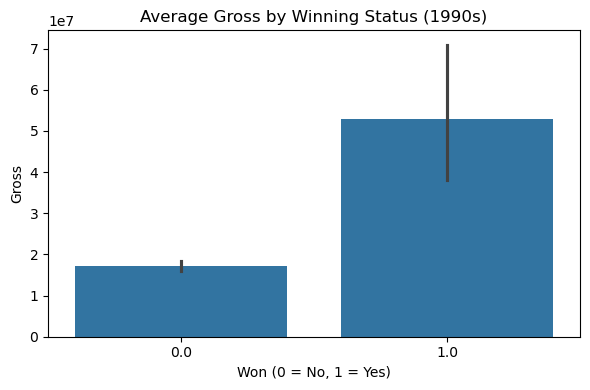

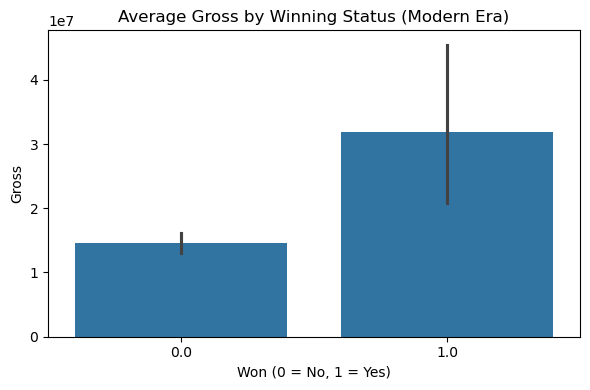

In [9]:
#90s bar chart 
plt.figure(figsize=(6,4))
sns.barplot(data=movies_90s, x="Won", y="Gross", errorbar="ci")
plt.title("Average Gross by Winning Status (1990s)")
plt.xlabel("Won (0 = No, 1 = Yes)")
plt.ylabel("Gross")
plt.tight_layout()
plt.show()

#Modern bar chart 
plt.figure(figsize=(6,4))
sns.barplot(data=movies_modern, x="Won", y="Gross", errorbar="ci")
plt.title("Average Gross by Winning Status (Modern Era)")
plt.xlabel("Won (0 = No, 1 = Yes)")
plt.ylabel("Gross")
plt.tight_layout()
plt.show()